In [1]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np


In [2]:
# seaborn settings, research paper style, and palette
sns.set_context("paper")
# sns.set_palette("husl")

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def get_latest_event_file(event_dir):
    event_files = os.listdir(event_dir)
    event_files.sort(key=lambda f: os.path.getmtime(os.path.join(event_dir, f)))
    return event_files[-1]

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "smth_value": [], "step": []})
    try:
        event_acc = EventAccumulator(path + "/" + get_latest_event_file(path))
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            smoothed_values = smooth(values, 0.5)
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "smth_value": smoothed_values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

# Baseline Policy Runs

In [ ]:
        # "bc_policy",
        # "ppo_base_policy",
        # "hrl_bc_ppo_policy_ws_mlp_dyn_clip",
        # "hrl_bc_ppo_policy_ws_feat_dyn_clip",
        # "hrl_bc_ppo_policy_ws_all_dyn_clip",
        # "hrl_ppo_policy_kl",
        # "hrl_ppo_policy_kl_ws_feat",
        # "hrl_exp_traj_reverse_ppo",
        # "hrl_exp_traj_reverse_ppo_ws_feat",

In [93]:
# load logs
tag_maps_s = {
    "bc_policy": ("BC", "Baseline"),
    "ppo_base_policy": ("PPO", "Baseline"),
    "hrl_bc_ppo_policy_ws_mlp_dyn_clip": ("MLP", "BCI"),
    "hrl_bc_ppo_policy_ws_feat_dyn_clip": ("FEAT", "BCI"),
    "hrl_bc_ppo_policy_ws_all_dyn_clip": ("ALL", "BCI"),
    "hrl_ppo_policy_kl": ("KL-P", "BCC"),
    "hrl_ppo_policy_kl_ws_feat": ("KL-F", "BCC"),
    "hrl_exp_traj_reverse_ppo": ("ER-P", "AE"),
    "hrl_exp_traj_reverse_ppo_ws_feat": ("ER-F", "AE"),
}

tag_maps = {
    "stochastic": tag_maps_s,
}

dfs = {}
for _main_tag, _tag_map in tag_maps.items():
    holder = list()
    for tag, tag_name in _tag_map.items():
        df = pd.read_csv(f"runs/policy_runs/run_{tag}_stochastic_log.csv")
        df['tag'] = tag
        df['tag_name'] = tag_name[0]
        df["group"] = tag_name[1]
        holder.append(df)

    df_logs = pd.concat(holder)
    dfs[_main_tag] = df_logs

In [99]:
df_logs.groupby(
    ["group", "tag_name"]
).agg(
    {
        "cum_rewards": ["mean", "std"],
        "completion": ["mean", "std"],
    }
).rename(columns={"mean": "mean_value", "std": "std_value"}).to_clipboard()

In [101]:
df_logs.to_clipboard()

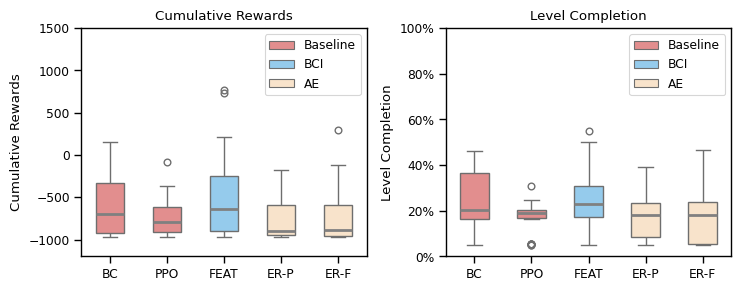

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(7.5,3))
axes = axes.flatten()
# axes = [axes]
# Remove the legend title

# =================================================================================
# stochastic
df_logs = dfs["stochastic"]
orders = [tag_name[0] for tag_name in tag_maps['stochastic'].values()]
mid_line_color = "gray"
# colors = ["lightcoral", "lightskyblue", "lightgreen", "thistle"]
colors = ["lightcoral", "lightskyblue", "bisque"]


g = sns.boxplot(data=df_logs, x='tag_name', y='cum_rewards', order=orders, width=0.5,
            medianprops={"color": mid_line_color, "linewidth": 2},
            ax=axes[0], hue="group", palette=colors)
axes[0].set_xlabel("")
axes[0].set_ylabel("Cumulative Rewards")
axes[0].set_title("Cumulative Rewards")
g.get_legend().set_title(None)

sns.boxplot(data=df_logs, x='tag_name', y='completion', order=orders, width=0.5,
            medianprops={"color": mid_line_color, "linewidth": 2},
            ax=axes[1], hue="group", palette=colors)
axes[1].set_xlabel("")
axes[1].set_ylabel("Level Completion")
axes[1].set_title("Level Completion")
axes[1].set_ylim(0, 1)

# Change y-axis to percentage format
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[0].set_ylim(-1200, 1500)
plt.tight_layout()
plt.legend()
plt.savefig("../project_final_report/figures/cum_rewards_ae.png", dpi=300, bbox_inches='tight')

# Getting BC-I Performance

In [87]:
experiments = {
    "ppo_base_policy": "PPO Baseline",
    # "hrl_bc_ppo_policy_ws_mlp_dyn_clip": "BCI-MLP",
    "hrl_bc_ppo_policy_ws_feat_dyn_clip": "BCI-FEAT",
    # "hrl_bc_ppo_policy_ws_all_dyn_clip": "BCI-ALL",
    
    # "hrl_ppo_policy_kl": "KL-P",
    # "hrl_ppo_policy_kl_ws_feat": "KL-F",
    "hrl_exp_traj_reverse_ppo": "ER-P",
    "hrl_exp_traj_reverse_ppo_ws_feat": "ER-F",
}

data_holders = []
for exp in experiments.keys():
    path = f"runs/{exp}/PPO_1"
    data = tflog2pandas(path)
    data["exp"] = exp
    data["label"] = experiments[exp]
    data_holders.append(data)

df = pd.concat(data_holders)

In [88]:
df["metric"].unique()

array(['time/fps', 'train/approx_kl', 'train/clip_fraction',
       'train/clip_range', 'train/entropy_loss',
       'train/explained_variance', 'train/learning_rate', 'train/loss',
       'train/mean_episode_reward', 'train/policy_gradient_loss',
       'train/std_episode_reward', 'train/value_loss'], dtype=object)

In [89]:
tmp = pd.pivot_table(
    df[df["metric"].isin(["train/mean_episode_reward", "train/std_episode_reward"])], 
    index=["label", "step"], 
    values="smth_value", 
    columns="metric"
).reset_index()
tmp["train/mean_episode_reward"] = tmp["train/mean_episode_reward"]

In [90]:
orders = list(experiments.values())
colors = sns.color_palette()

/tmp/ipykernel_1363017/1917560376.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t["entropy"] = - _t["smth_value"]
/tmp/ipykernel_1363017/1917560376.py:23: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data=_t, x='step', y='entropy', hue='label', palette=colors,


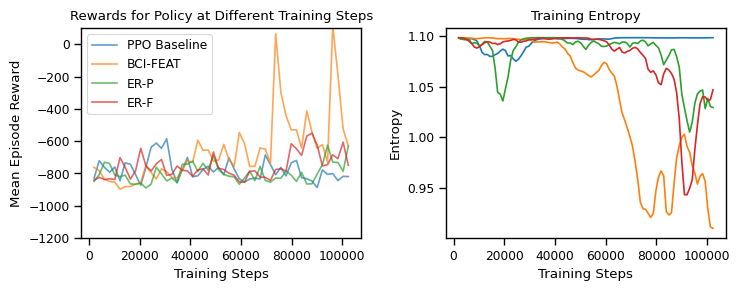

In [92]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))

# Plot the line with standard deviation as error bars
for i, cat in enumerate(orders):
    subset = tmp[tmp['label'] == cat]
    axes[0].plot(subset['step'], subset['train/mean_episode_reward'], color=colors[i], label=cat,
                 linestyle="-", alpha=.7)
    # if cat in ['BCI-FEAT', "PPO Baseline"]:
    #     z = np.polyfit(subset['step'], subset['train/mean_episode_reward'], 2)
    #     p = np.poly1d(z)
    #     axes[0].plot(subset['step'], p(subset['step']), color=colors[i], alpha=1, linestyle="--", linewidth=2)

axes[0].set_xlabel("Training Steps")
axes[0].set_ylabel("Mean Episode Reward")
axes[0].set_title("Rewards for Policy at Different Training Steps")
axes[0].set_ylim(-1200, 100)
axes[0].legend()

# Plot the training entropy loss
_t = df.loc[df['metric'] == "train/entropy_loss", :]
_t["entropy"] = - _t["smth_value"]
sns.lineplot(data=_t, x='step', y='entropy', hue='label', palette=colors, 
             hue_order=orders, ax=axes[1])
axes[1].set_xlabel("Training Steps")
axes[1].set_ylabel("Entropy")
axes[1].set_title("Training Entropy")
axes[1].get_legend().remove()

plt.tight_layout()
# plt.show()
plt.savefig("../project_final_report/figures/ae-training.png", dpi=300, bbox_inches='tight')
